In [1]:
import os

os.environ["KAGGLE_USERNAME"] = "mohammeds3d"
os.environ["KAGGLE_KEY"] = (
    "2b004b125edec969d6964140c147aea7"  # don't abuse it please (e.g. don't run the next cell billions of times)
)

import kaggle

In [2]:
# Download the dataset
if os.path.exists("data"):
    print("Data already exists.")
else:
    kaggle.api.competition_download_files("isic-2024-challenge", path="data")
    import zipfile

    with zipfile.ZipFile("data/isic-2024-challenge.zip", "r") as zip_ref:
        zip_ref.extractall("data")
    os.remove("data/isic-2024-challenge.zip")
    print("Data downloaded and extracted.")

Data already exists.


In [3]:
import torch
import numpy as np

torch.manual_seed(471)
SEED = 471
# set device
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")

# supress warnings
import warnings

# warnings.filterwarnings("ignore")

Using device: mps


In [4]:
# metadata
import pandas as pd

metadata = pd.read_csv("data/train-metadata.csv")

# now, we are only interested in the image path and the target #TODO: consider using other features
metadata = metadata[["isic_id", "target"]]

# check the statistics of the target, to see if it's balanced??
# perentage of each class
metadata["target"].value_counts(normalize=True)

/var/folders/vx/m5st89kx5flb1_rzmmy1rpcc0000gn/T/ipykernel_8766/889081294.py:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("data/train-metadata.csv")


target
0    0.99902
1    0.00098
Name: proportion, dtype: float64

In [5]:
# okay, it's not balanced, with huge difference between the two classes! data augmentation? upsampling? downsampling? class weights?
# #TODO: consider using other techniques

In [6]:
# Load the data, display few images
# coustom dataset
from torch.utils.data import Dataset
from PIL import Image


class ISICDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform
        self.images = metadata["isic_id"]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = f"data/train-image/image/{self.metadata.iloc[idx, 0]}.jpg"
        image = Image.open(image_path)
        label = self.metadata.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

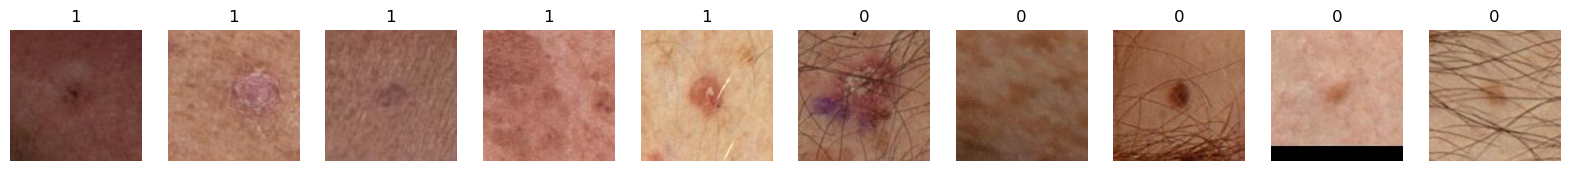

In [7]:
# display few images, for each class
import matplotlib.pyplot as plt

# get three random indices target = 0
indicesneg = metadata[metadata["target"] == 0].sample(5).index
# get three random indices target = 1
indicespos = metadata[metadata["target"] == 1].sample(5).index

fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(5):
    image, label = ISICDataset(metadata).__getitem__(indicespos[i])
    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis("off")
    image, label = ISICDataset(metadata).__getitem__(indicesneg[i])
    axes[i + 5].imshow(image)
    axes[i + 5].set_title(label)
    axes[i + 5].axis("off")
plt.show()

In [8]:
# split the data into train and test first, make sure to stratify the split
# 30% test, 70% train, (50%, 50%  each class in the test)
from sklearn.model_selection import train_test_split

# take 30% of the data as test, 15% of each class
# choose random rows with target = 1. n = 393.
# 393 * 0.3 = 118

df_test = pd.concat(
    [
        metadata[metadata["target"] == 1].sample(118, random_state=SEED),
        metadata[metadata["target"] == 0].sample(118, random_state=SEED),
    ]
)
df_train = metadata.drop(df_test.index)  # drop the test indices

# now consider the rest of positive (393-118) and negative as well
# 275 and 275. TODO: consider other ratios, and the rest of the dataset.
df_train = pd.concat(
    [
        df_train[df_train["target"] == 1].sample(275, random_state=SEED),
        df_train[df_train["target"] == 0].sample(275, random_state=SEED),
    ]
)

# check the percentage of each class in the test
print("test")
print(df_test["target"].value_counts(normalize=True))
print(len(df_test))
print("train")
print(df_train["target"].value_counts(normalize=True))
print(len(df_train))

test
target
1    0.5
0    0.5
Name: proportion, dtype: float64
236
train
target
1    0.5
0    0.5
Name: proportion, dtype: float64
550


In [9]:
# 15% validation, 70% train
df_train, df_val = train_test_split(
    df_train, test_size=0.15, stratify=df_train["target"], random_state=SEED
)
### transformations. TODO: consider using data augmentation techniques more often with the minority class! #NOTE: IMPORTANT
from torchvision import transforms

transform_train = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # data augmentation. #NOTE: not considering the class imbalance here, consider using more data augmentation techniques with the minority class
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transform_val = transform_train = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# create the datasets
train_data = ISICDataset(df_train, transform=transform_train)
val_data = ISICDataset(df_val, transform=transform_val)

# create the dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:
# create the model
from torchvision import models
import torch.nn as nn

# model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.IMAGENET1K_V1")
# freeze the parameters if
# for param in model.parameters():
#    param.requires_grad = False

# add few layers (efficientnet)
model = nn.Sequential(
    model,
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    # no need for sigmoid, as we will use BCEWithLogitsLoss
)


# move the model to the device
model = model.to(device)

In [ ]:
# loss function
from torch.nn import BCEWithLogitsLoss

loss_fn = BCEWithLogitsLoss(pos_weight=torch.tensor([2 / 1]).to(device))
# TODO: change the pos_weight, consider other loss functions as well.
# NOTE: pos_weight is used to balance the classes, as the dataset is imbalanced.

# optimizer #TODO: consider using other optimizers
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)

epochs = 10

In [13]:
# define the training loop
from sklearn.metrics import roc_auc_score  # auc

# for early stopping
best_val_loss = float("inf")
patience_counter = 0
minimum_change = 0.01
patience = 3


# ploting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    # training
    model.train()
    train_loss = 0
    train_acc = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.float().view(-1, 1).to(device)
        optimizer.zero_grad()

        output = model(inputs)

        loss = loss_fn(output, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # accuracy
        predicted = torch.sigmoid(output).round()
        train_acc += (predicted == labels).sum().item()

    # validation
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for batch_idx, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.float().view(-1, 1).to(
                device
            )

            output = model(vinputs)
            loss = loss_fn(output, vlabels)

            val_loss += loss.item()

            # accuracy
            predicted = torch.sigmoid(output).round()
            val_acc += (predicted == vlabels).sum().item()
            
            ##compute auc
            auc = roc_auc_score(vlabels.cpu().numpy(), output.cpu().numpy())

    # print results
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(
        f"Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}\n"
        + f"Val loss: {val_loss:.4f}, accuracy: {val_acc:.4f}\n"
        + f"Val AUC: {auc:.4f}"
    )

    # early stopping
    if best_val_loss - val_loss > minimum_change:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

Epoch 1
-------------------------------
Train loss: 0.1408, accuracy: 0.9615
Val loss: 0.8901, accuracy: 0.8554
Val AUC: 0.9205
Epoch 2
-------------------------------
Train loss: 0.1491, accuracy: 0.9615
Val loss: 0.9902, accuracy: 0.8434
Val AUC: 0.9205
Epoch 3
-------------------------------
Train loss: 0.0932, accuracy: 0.9722
Val loss: 0.5497, accuracy: 0.8313
Val AUC: 0.9318
Epoch 4
-------------------------------
Train loss: 0.1040, accuracy: 0.9700
Val loss: 0.6887, accuracy: 0.8434
Val AUC: 0.9432
Epoch 5
-------------------------------
Train loss: 0.0781, accuracy: 0.9829
Val loss: 0.5216, accuracy: 0.8434
Val AUC: 0.9773
Epoch 6
-------------------------------
Train loss: 0.0742, accuracy: 0.9829
Val loss: 0.5302, accuracy: 0.8916
Val AUC: 0.9773
Epoch 7
-------------------------------
Train loss: 0.0532, accuracy: 0.9807
Val loss: 0.5839, accuracy: 0.8193
Val AUC: 0.9773
Epoch 8
-------------------------------
Train loss: 0.0476, accuracy: 0.9914
Val loss: 0.5460, accuracy:

In [14]:
# evaluate the model on the test set
df_test = ISICDataset(df_test, transform=transform_val)
test_loader = DataLoader(df_test, batch_size=32, shuffle=False)

model.eval()
test_acc = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for batch_idx, tdata in enumerate(test_loader):
        tinputs, tlabels = tdata
        tinputs = tinputs.to(device)

        output = model(tinputs)

        predicted = torch.sigmoid(output).round()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(tlabels.numpy())


# auc, confusion matrix, accuracy, precision, recall, f1-score
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
)

auc = roc_auc_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion matrix:")
print(conf_matrix)

AUC: 0.8136
Accuracy: 0.8136
Confusion matrix:
[[94 24]
 [20 98]]
